# Data preparation/exploration for the Aguathon

## Problem definition

Find the best model that predict the level of the Evro river when cros Zaragoza.

----

## Index

1. [Import modules and Data](#first-bullet)
2. [Missing Values](#second-bullet)
3. [Feature engineering](#third-bullet)
    * Split the data in train and test set
4. [Random forest regressor](#forth-bullet)
    * Cross-validation

## Import modules and Data <a class="anchor" id="first-bullet"></a>

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 1


from __future__ import print_function

# STD lib imports
import os
import sys

# Third party libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklear stuff
from sklearn.model_selection import train_test_split

# root path of the project
PROJ_ROOT = os.path.join(os.pardir)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.make_dataset
import data.make_dataset as md

print(os.path.abspath(PROJ_ROOT))

raw_file = 'datos.csv'
path = '../ENTRADA/'

raw_data = pd.read_csv(os.path.join(path, raw_file))
raw_data.head()

/Users/miloc/Documents/git-hub/Apsu


,time,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h
0,2008-01-01 00:00:00,0.8100,0.4375,1.6000,0.2675,0.7875,0.74,False,0.750,0.7400,0.76
1,2008-01-01 01:00:00,0.8100,0.4725,1.6075,0.2650,0.7900,0.74,False,0.745,0.7325,0.76
2,2008-01-01 02:00:00,0.8100,0.5425,1.6100,0.2675,0.7900,0.74,False,0.740,0.7300,0.76
3,2008-01-01 03:00:00,0.8075,0.5500,1.6100,0.2600,0.7900,0.74,False,0.740,0.7200,0.76
4,2008-01-01 04:00:00,0.8000,0.5525,1.6025,0.2650,0.7900,0.74,False,0.740,0.7200,0.76


## Missing Values <a class="anchor" id="second-bullet"></a>

In [2]:
# List the columns that contain missing values
raw_data.isnull().any()

time           False
ALAGON_NR       True
GRISEN_NR       True
NOVILLAS_NR     True
TAUSTE_NR       True
TUDELA_NR       True
ZGZ_NR         False
RIESGO         False
pred_24h       False
pred_48h       False
pred_72h       False
dtype: bool

In [3]:
# Most simple thing, remove missing values
data_s1 = raw_data.dropna()
data_s1.isnull().any()

time           False
ALAGON_NR      False
GRISEN_NR      False
NOVILLAS_NR    False
TAUSTE_NR      False
TUDELA_NR      False
ZGZ_NR         False
RIESGO         False
pred_24h       False
pred_48h       False
pred_72h       False
dtype: bool

0.0


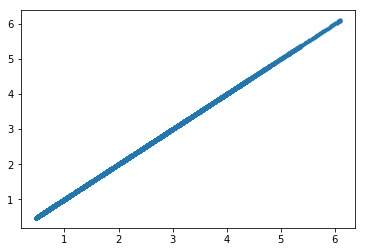

In [4]:
# review if the future predictions are concistent
ft = 72
print(np.sum(raw_data.ZGZ_NR.values[ft:] - raw_data['pred_{}h'.format(ft)].values[:-ft]))
plt.plot(raw_data.ZGZ_NR.values[ft:], raw_data['pred_{}h'.format(ft)].values[:-ft], '.')

## Feature engineering <a class="anchor" id="third-bullet"></a>

In [5]:
# No feature engineering yet
columns_x = ['ALAGON_NR', 'GRISEN_NR', 'NOVILLAS_NR', 'TAUSTE_NR', 'TUDELA_NR', 'ZGZ_NR', 'RIESGO']
columns_y = ['pred_24h', 'pred_48h', 'pred_72h']
X = data_s1[columns_x]
Y = data_s1[columns_y[0]]

### Split the data in train and test set

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

## Random forest regressor <a class="anchor" id="forth-bullet"></a>

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(max_depth=2, 
                                     random_state=0,
                                     n_estimators=100)

rf_regressor.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [8]:
print('r2_score = %0.2f' % rf_regressor.score(x_test, y_test))

r2_score = 0.91


### Cross-validation

In [9]:
from sklearn.model_selection import cross_val_score

scores = (cross_val_score(rf_regressor, X, Y, scoring='neg_mean_squared_error', cv=5))*-1

print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.05 (+/- 0.03)


In [10]:
scores

array([ 0.04712265,  0.03385503,  0.05381924,  0.03942502,  0.07703737])